### Load the Modules and Data ###

I also rename some of the objectives so that it makes more intuitive sense that they should be minimized.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench.util import load_results
experiments, outcomes = load_results(r'all_exploitation_10000_1.tar.gz')

In [5]:
outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

### Let's do a first visualization of the outcome space ###

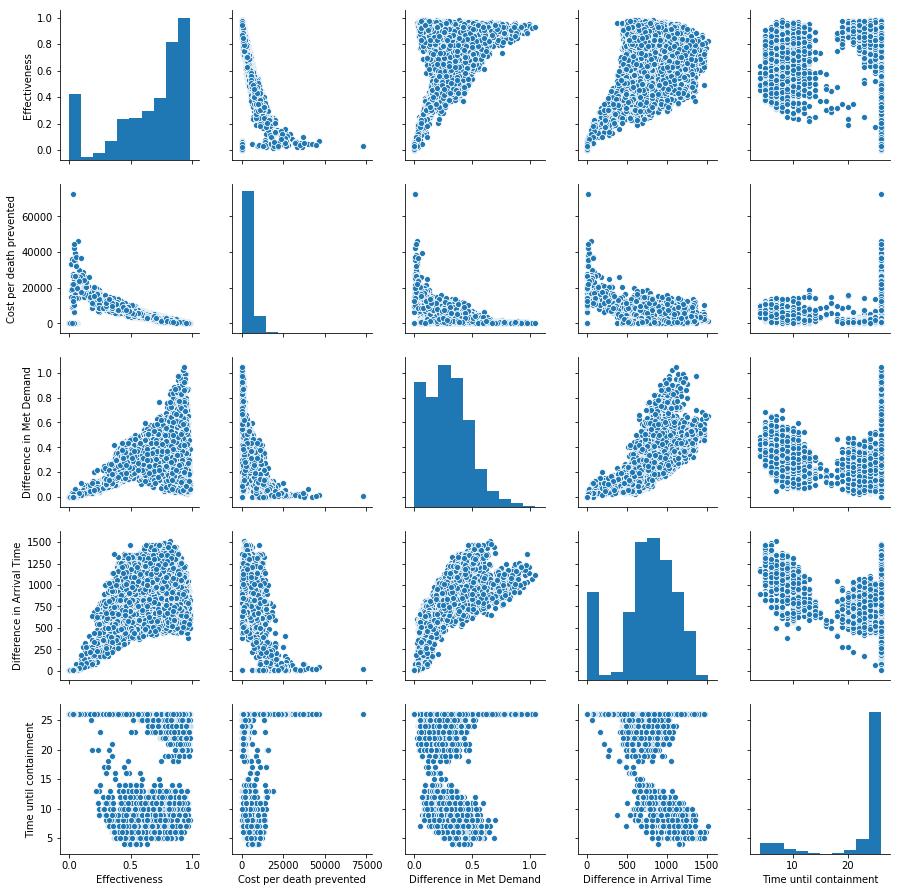

In [6]:
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

Some quick data cleaning for the quantitative analysis

In [7]:


cleaned_experiments = experiments.drop(labels=['exploration_ratio','policy','model'], axis=1)
cleaned_experiments = cleaned_experiments.rename(columns={'scenario_id': 'scenario'})

cleaned_experiments2 = cleaned_experiments.drop(labels=['scenario'], axis=1)

### Quantitative Analysis ###

First, we want to learn about the influence the uncertain input factors have on the model outcomes in general. For this feature scoring is used, which determines the influence of input factors using extremely randomized trees (extra trees) regression.

C:\Users\Emma\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<IPython.core.display.Javascript object>


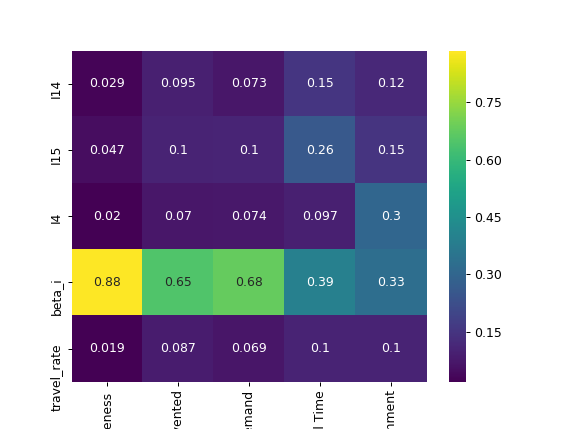

In [8]:
%matplotlib notebook

from ema_workbench.analysis import feature_scoring



fs = feature_scoring.get_feature_scores_all(cleaned_experiments2, outcomes)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

This shows that the community transmission rate (beta_i) is the most influential input factor for all objectives. For Effectiveness it is by far the most impotant one, whereas for Cost per Death Prevented and Difference in Met Demand the combined influence of all the other factors also plays a role. For Difference in Arrival Time the transmission rate is still the most influential, but the initial number of patients in regions 15 also has influence. Finally when studying the speed of the response, the transmission rate and the intitial number of patients in region 4 have the most influence.

Notably, the initial number of patients in region 14 and the travel rate do not seem te have a lot of influence on any of the factors.

Now we know the overall influence of the uncertain inputs at it seems that the transmission rate has by far the most effect. But we do not know the direction of this influence, nor does it explain the behaviours identified in the visual analysis of the scatterplot.

### Effectiveness ###

First, let's investigate the hypothesis from the qualitative analysis that low effectiveness rates are, counter-intuitively, caused by low transmissions. For this we can use PRIM, to see which parts of the input space correspond to specific sections of the outcome-space.

[MainProcess/INFO] 10000 points remaining, containing 1253 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.6622390891840607, returning dump box


<IPython.core.display.Javascript object>


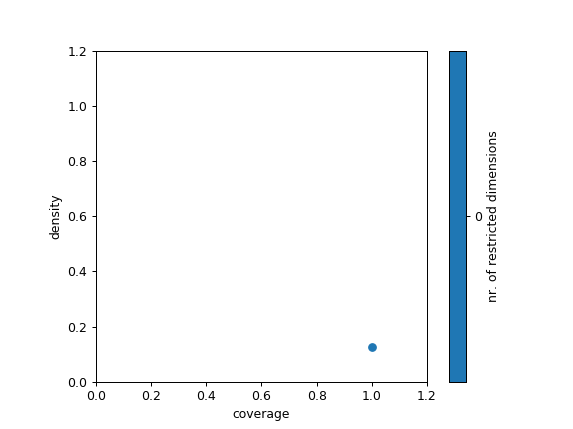

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

from ema_workbench.analysis import prim
from ema_workbench import ema_logging

x = cleaned_experiments

y = outcomes['Effectiveness'] <= 0.2


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

PRIM cannot find a a subspace in the input space which sufficiently explains efficiency scores under 0.2. This could mean that those poor scores are still due to the stochasticity in the spontaneous news mechanism, but that this is not strongly related to low transmission rates and intitial cases but more to simple ''bad luck''. 

However, with a high number of cases the probabiltiy of not receiving spontaneous news would become neligible, so high scores in efficiency could still be related to high transmission rates. Let's investigate using PRIM:

[MainProcess/INFO] 10000 points remaining, containing 4499 cases of interest
[MainProcess/INFO] mean: 0.9983566146261298, mass: 0.1217, coverage: 0.270060013336297, density: 0.9983566146261298 restricted_dimensions: 4


<IPython.core.display.Javascript object>


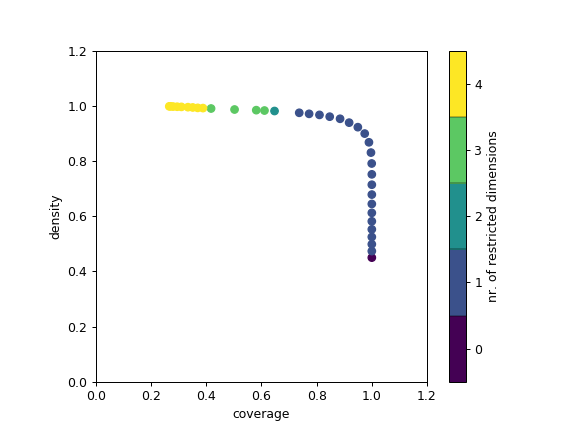

In [10]:
y = outcomes['Effectiveness'] > 0.8


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box2 = prim_alg.find_box()

box2.show_tradeoff()
plt.show()

coverage    0.949322
density     0.922861
id                15
mass          0.4628
mean        0.922861
res_dim            1
Name: 15, dtype: object

          box 15                       
             min       max    qp values
beta_i  0.314883  0.499961  [0.0, -1.0]



<IPython.core.display.Javascript object>


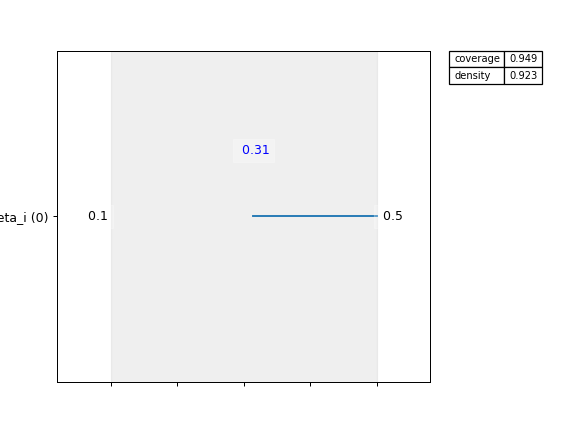

In [11]:
box2.inspect(15)
box2.inspect(15, style='graph')
plt.show()

And indeed, PRIM shows that high scores in effectiveness strongly correspond to transmission rate inputs in the upper half of its range. Following the ''bad luck'' hypothesis, this would suggest that the wide range of cases between 0.0 and 0.8 scores of effectiness is then predominantly explained by the stochasticity of the ''spontaneous news''  mechanism when the number of patients in a region remains below 80 for a longer time.



[MainProcess/INFO] 10000 points remaining, containing 5501 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4176, coverage: 0.7591347027813125, density: 1.0 restricted_dimensions: 1


<IPython.core.display.Javascript object>


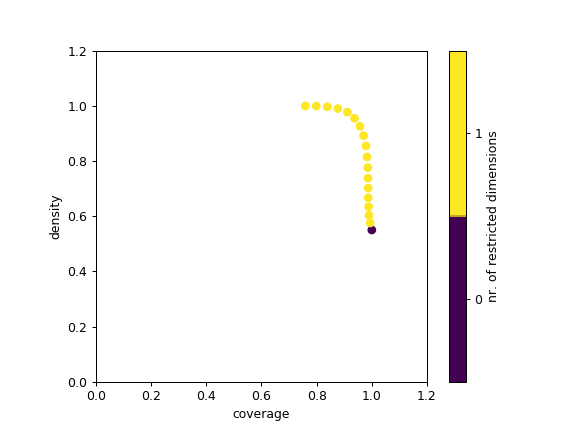

In [12]:
y = outcomes['Effectiveness'] <= 0.8


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box3 = prim_alg.find_box()

box3.show_tradeoff()
plt.show()

coverage    0.911289
density     0.977384
id                13
mass          0.5129
mean        0.977384
res_dim            1
Name: 13, dtype: object

          box 13                       
             min       max    qp values
beta_i  0.100037  0.305145  [-1.0, 0.0]



<IPython.core.display.Javascript object>


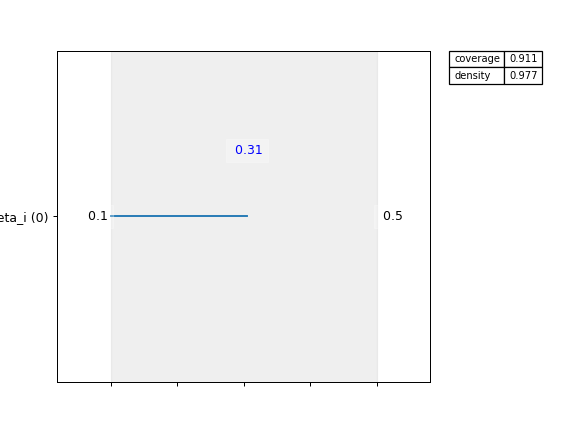

In [13]:
box3.inspect(13)
box3.inspect(13, style='graph')
plt.show()

PRIM shows that the wide range of scores in effectivenes (0.0 to 0.8) is only influenced by the transmission rate, while being unable to identify factors which explain the division within this set. This supports the ''bad luck'' hypothesis.

Let's use dimenional stacking to check these results:


<IPython.core.display.Javascript object>


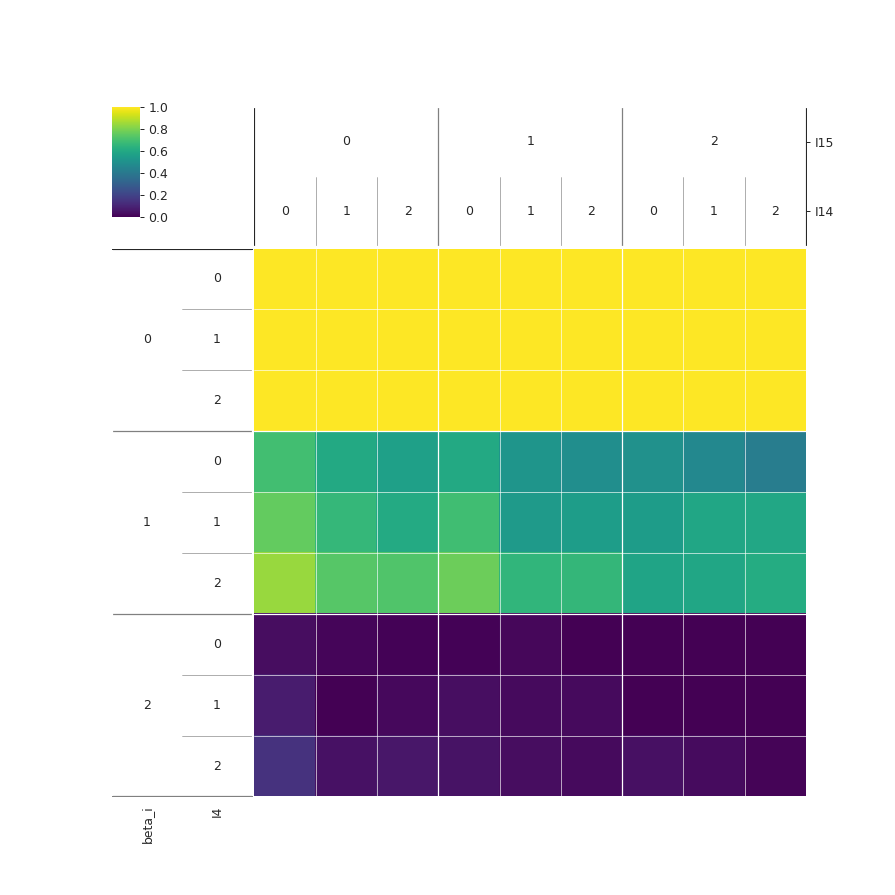

In [14]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import dimensional_stacking

x = cleaned_experiments
y = outcomes['Effectiveness'] < 0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

<IPython.core.display.Javascript object>


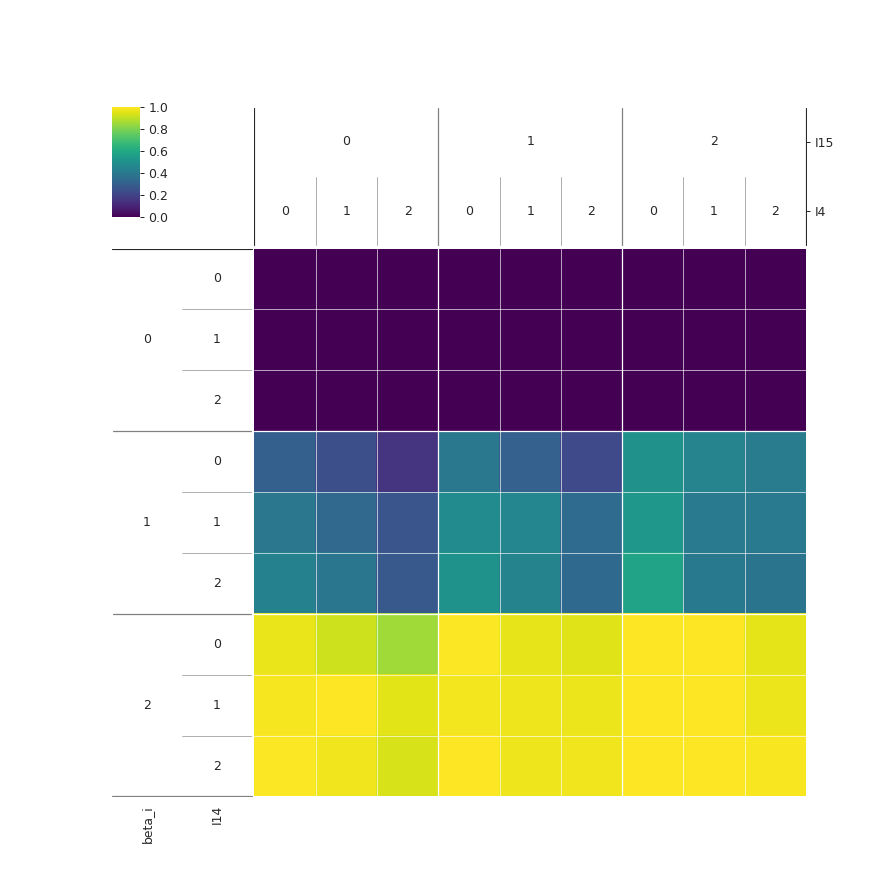

In [15]:
y = outcomes['Effectiveness'] > 0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

Dimensional stacking confirms that the community transmission rate beta_i is the most important factor that explains differences in effectivness scores. 

Additionally, a small influence of I4 is visible, showing that if region 4 has a high number of cases, this actually leads to lower performance. This is because the number of intial cases in region 4 is small (with a maximum of 8 initial cases), meaning it will take a long time before it has a significant chance of generating spontaneous news (i.e. for 7 initial cases and a transmission rate of 0.32 it reaches 80 infections only after 23 timesteps, at which point the probability of spontaneous news approaches 1). This means that a high intial number of cases will lead to region 4 contributing a relatively large amount of deaths given its low chance of discovery.

### Cost per death prevented ###

Not a lot of (unexpected) variation in cost per live saved. Let's see if within reasonable scores we can still find out what is good. First we want to remove the outliers to get a better sense of the "normal" values.

In [16]:

condition = (outcomes['Cost per death prevented'] < 25000)
extracted = np.extract(condition, outcomes['Cost per death prevented'])

print(np.mean(extracted))
print(np.std(extracted))
print(np.median(extracted))

2910.2536097590505
3317.725571973243
1648.9819159789558


Let's look at the "best" half (median and under) of the results - PRIM can't find a good box, so let's try with the mean

[MainProcess/INFO] 10000 points remaining, containing 6493 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4176, coverage: 0.6431541660249499, density: 1.0 restricted_dimensions: 1


<IPython.core.display.Javascript object>


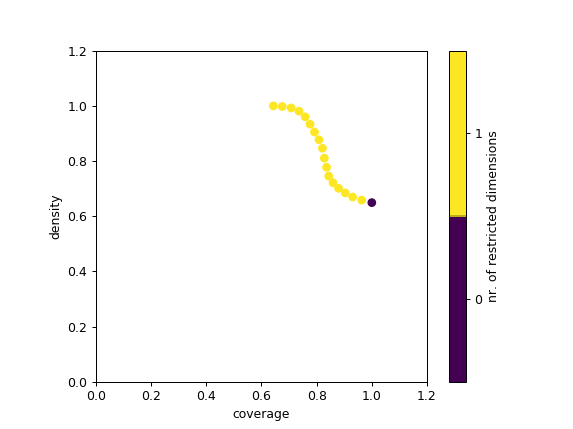

In [17]:
y = outcomes['Cost per death prevented'] <= 2910


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box4 = prim_alg.find_box()

box4.show_tradeoff()
plt.show()

coverage    0.821038
density     0.846325
id                 9
mass          0.6299
mean        0.846325
res_dim            1
Name: 9, dtype: object

           box 9                                          
             min       max                       qp values
beta_i  0.248039  0.499961  [4.301631409737962e-269, -1.0]



<IPython.core.display.Javascript object>


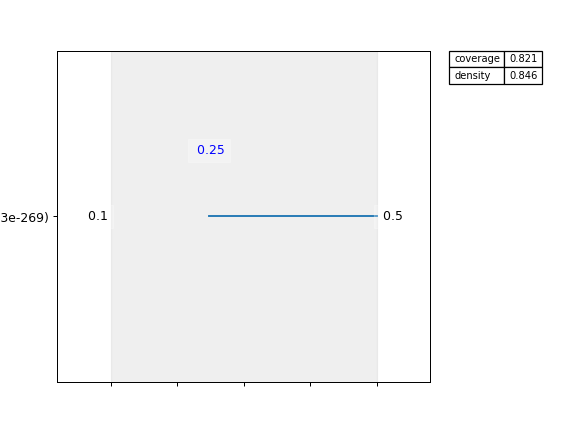

In [18]:
box4.inspect(9)
box4.inspect(9, style='graph')
plt.show()

So that's probably directly related to the effectiveness thing where high transmission rates cause high effectiveness 

[MainProcess/INFO] 10000 points remaining, containing 3507 cases of interest
[MainProcess/INFO] mean: 0.9351145038167938, mass: 0.0524, coverage: 0.13972055888223553, density: 0.9351145038167938 restricted_dimensions: 4


<IPython.core.display.Javascript object>


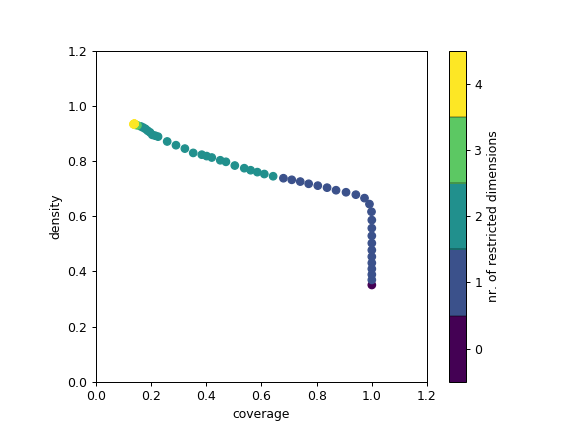

In [19]:
y = outcomes['Cost per death prevented'] > 2910


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box5 = prim_alg.find_box()

box5.show_tradeoff()
plt.show()

coverage    0.740519
density     0.725622
id                20
mass          0.3579
mean        0.725622
res_dim            1
Name: 20, dtype: object

         box 20                                         
            min       max                      qp values
beta_i  0.14335  0.286508  [1.9074342261036624e-08, 0.0]



<IPython.core.display.Javascript object>


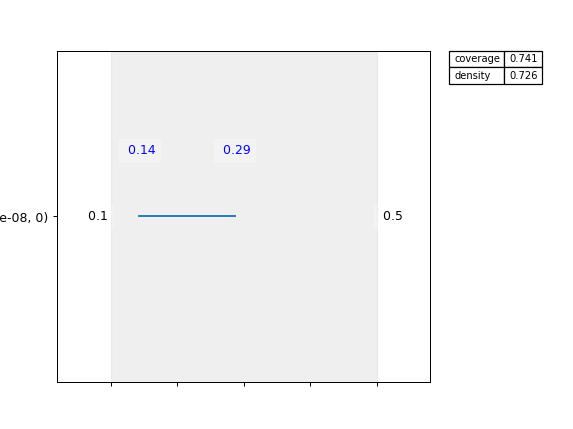

In [20]:
box5.inspect(20)
box5.inspect(20, style='graph')
plt.show()

Yeah so basically cost isn't that interesting - pretty directly related to effectiveness it seems.

### Equity - Difference in Met Demand ###
Given the visual inspection, there are two questions that are interesting for quantitative analysis:
- What factors are related to good performance on this objective?
- What causes the wide distribution of difference in met demand scores when effectiveness is high?

Let's start out with the first one

[MainProcess/INFO] 10000 points remaining, containing 7381 cases of interest
[MainProcess/INFO] mean: 0.9319727891156463, mass: 0.0588, coverage: 0.07424468229237231, density: 0.9319727891156463 restricted_dimensions: 5


<IPython.core.display.Javascript object>


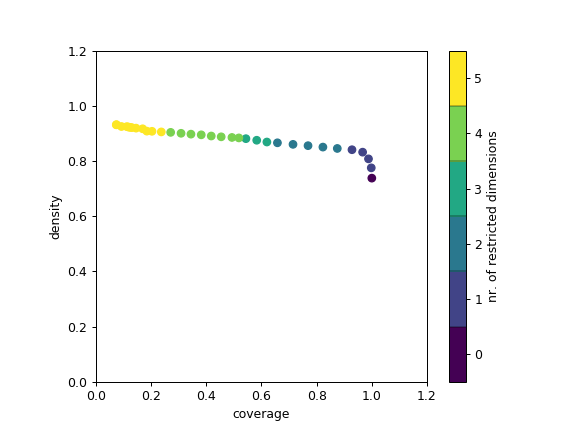

In [29]:
y = outcomes['Difference in Met Demand'] <= 0.4


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box6 = prim_alg.find_box()

box6.show_tradeoff()
plt.show()

coverage    0.822653
density     0.850658
id                 6
mass          0.7138
mean        0.850658
res_dim            2
Name: 6, dtype: object

            box 6                                          
              min        max                      qp values
beta_i   0.100037   0.425749  [-1.0, 1.135835251604094e-97]
I15     25.000000  38.500000   [-1.0, 0.013729011677829982]



<IPython.core.display.Javascript object>


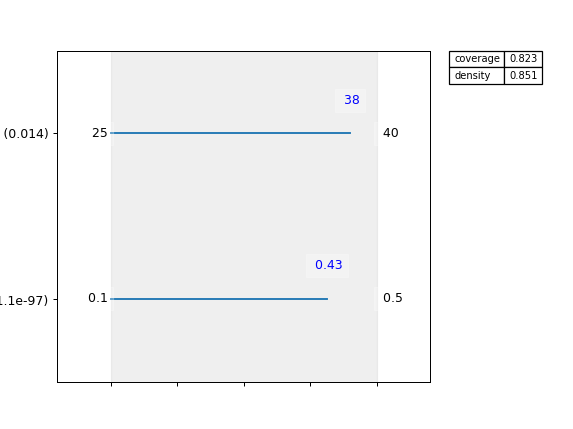

In [31]:
box6.inspect(6)
box6.inspect(6, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 2619 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.45016611295681064, returning dump box


<IPython.core.display.Javascript object>


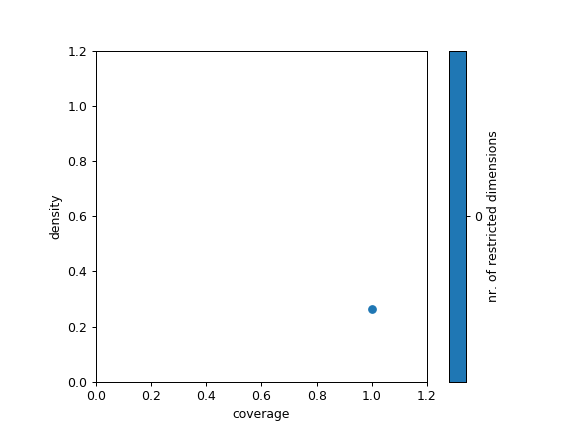

In [34]:
y = outcomes['Difference in Met Demand'] > 0.4


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box7 = prim_alg.find_box()

box7.show_tradeoff()
plt.show()

So there seems to be some relation between reasonable scores in difference in met demand and not having the highest values for community transmission or initial number of cases in region 15. This trend is also visible at scores < 0.3 though less convincingly, and PRIM cannot show it is significant at scores < 0.2

What do these results tell us? 
Higher transmission rates lead to bigger unmet demand in regions where no response is active, but this does not explain why the difference in met and unmet demand is bigger because if no ETCs are active in an area, the fraction of met/unmet demand is zero regardless of the size of the unmet demand.

The influence of the initial cases in region 15 is also hard to explain at first glance. It might be helpful to first note the absence of influence from the travel rate. What does this abscence imply? You would think that this is important in met demand, as higher travel rates would result in more cases in more regions, leading to poorer met demand scores as these regions are unlikely to be discovered by an all-eploitative strategy. Its abscence suggests that, contrary to expectations, travel rate does not have a significant influence - which can be extrapolated into saying that small numbers of cases in multiple regions are not the dominant factor in determining met demand equity. 

This due to the way the objective is calculated. The objective looks at the difference between the ratio of unmet/met demand between regions, not at the absolute difference in demand. I.e., if regions have 2 or 5 cases, it doesn't matter since they are still likely not discovered by the all-exploitative policy, so the cummulative patients is 0. That means all these regions have met demand scores of 0. Therefore

Then why is it important to not have the maximum transmission rate and initial number of cases in region 15 for reasonable equity in met demand scores? High transmission rates in regions which are likely to be discovered (i.e. 14, 15)  -- more patients??

Let's use dimensional stacking




<IPython.core.display.Javascript object>


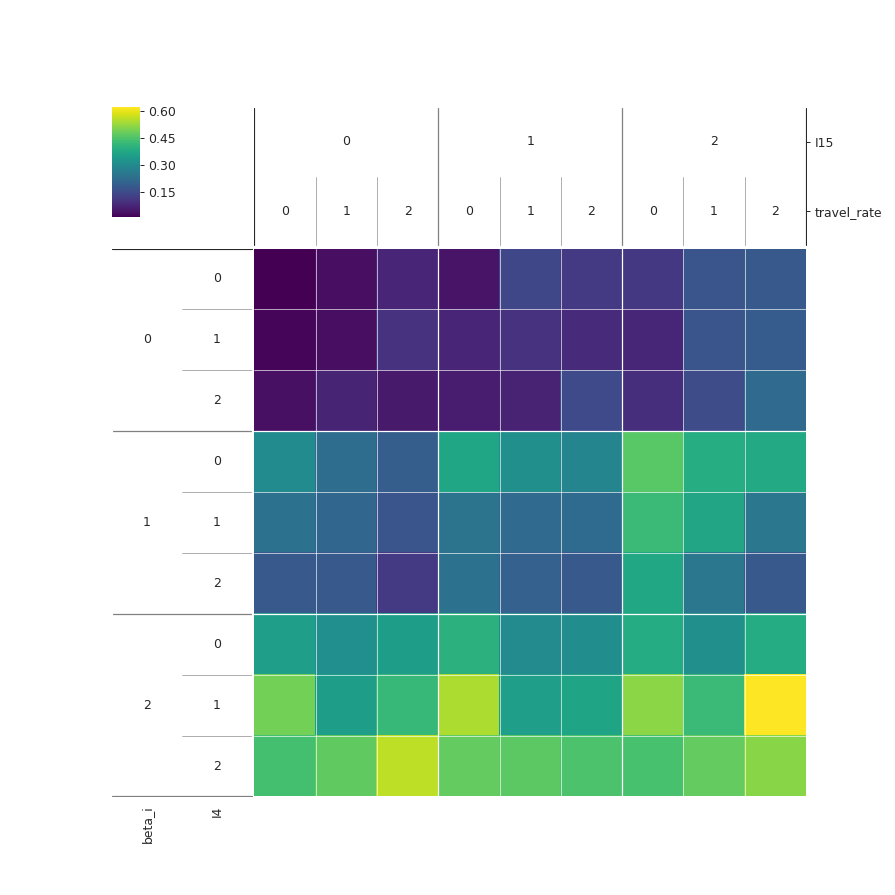

In [37]:
y = outcomes['Difference in Met Demand'] > 0.4
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

Moving on to the wide spread of equity scores given high efficiency

[MainProcess/INFO] 10000 points remaining, containing 2816 cases of interest
[MainProcess/INFO] mean: 0.9883720930232558, mass: 0.0516, coverage: 0.18110795454545456, density: 0.9883720930232558 restricted_dimensions: 5


<IPython.core.display.Javascript object>


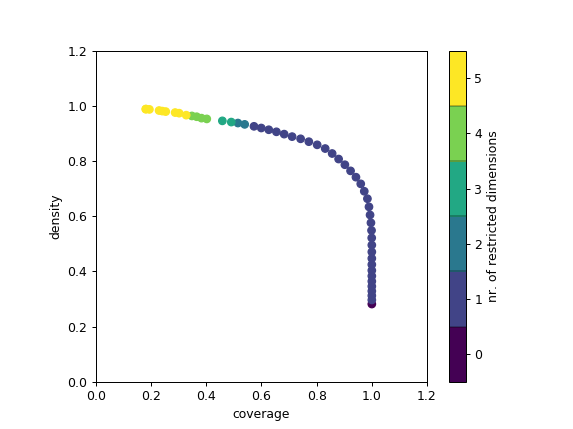

In [38]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] < 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box8 = prim_alg.find_box()

box8.show_tradeoff()
plt.show()    


coverage    0.830966
density     0.845376
id                25
mass          0.2768
mean        0.845376
res_dim            1
Name: 25, dtype: object

          box 25                                          
             min       max                       qp values
beta_i  0.332052  0.442749  [0.0, 1.4417131394441456e-155]



<IPython.core.display.Javascript object>


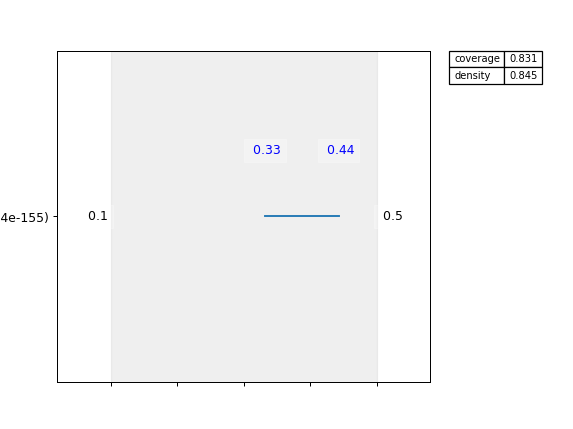

In [40]:
box8.inspect(25)
box8.inspect(25, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1683 cases of interest
[MainProcess/INFO] mean: 0.8874045801526718, mass: 0.0524, coverage: 0.27629233511586454, density: 0.8874045801526718 restricted_dimensions: 4


<IPython.core.display.Javascript object>


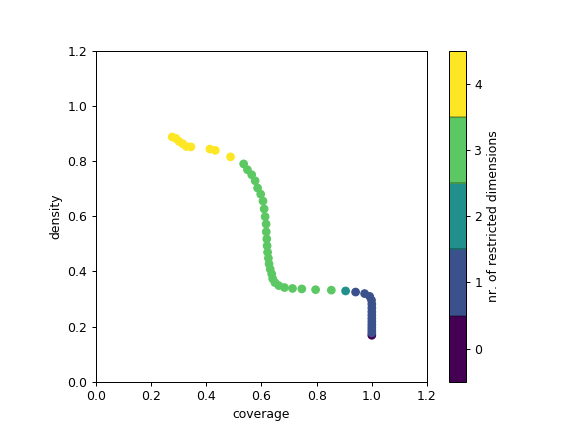

In [42]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] > 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box9 = prim_alg.find_box()

box9.show_tradeoff()
plt.show()   

That's a weird as fuck shape. Hmm, maybe this is to do with the linearity of the outcome and this is where you would do PCA? Let's try dimensional stacking for now:



<IPython.core.display.Javascript object>


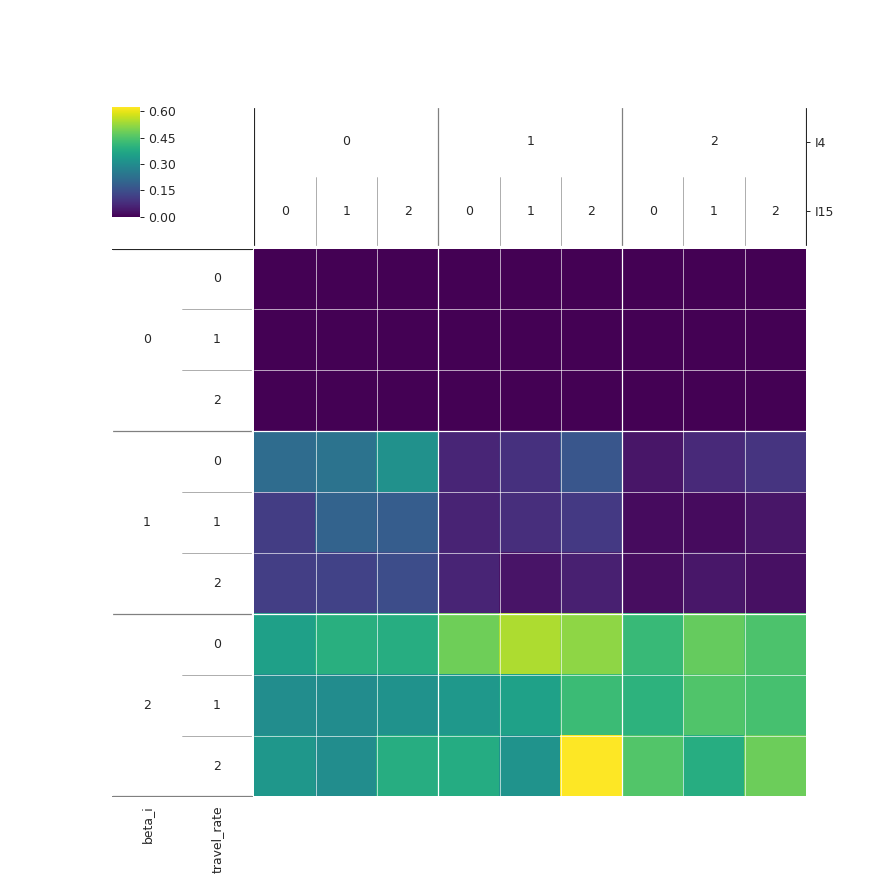

In [45]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] > 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=3)
plt.show()